In [21]:
import numpy as np
import pandas as pd

In [22]:
df = pd.read_csv('../datasets/earthquake_dataset/Indian_earthquake_data.csv')

In [23]:
df.head()

,Origin Time,Latitude,Longitude,Depth,Magnitude,Location
0,2021-07-31 09:43:23 IST,29.06,77.42,5.0,2.5,"53km NNE of New Delhi, India"
1,2021-07-30 23:04:57 IST,19.93,72.92,5.0,2.4,"91km W of Nashik, Maharashtra, India"
2,2021-07-30 21:31:10 IST,31.50,74.37,33.0,3.4,"49km WSW of Amritsar, Punjab, India"
3,2021-07-30 13:56:31 IST,28.34,76.23,5.0,3.1,"50km SW of Jhajjar, Haryana"
4,2021-07-30 07:19:38 IST,27.09,89.97,10.0,2.1,"53km SE of Thimphu, Bhutan"


In [24]:
df.drop(columns=['Origin Time','Location'],inplace=True)

In [25]:
df.head()

,Latitude,Longitude,Depth,Magnitude
0,29.06,77.42,5.0,2.5
1,19.93,72.92,5.0,2.4
2,31.50,74.37,33.0,3.4
3,28.34,76.23,5.0,3.1
4,27.09,89.97,10.0,2.1


In [26]:
df.shape

(2719, 4)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 4, 'rf__max_depth': 20, 'rf__bootstrap': True}
📊 Accuracy: 0.678

Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.49      0.31        41
           1       0.74      0.57      0.65       405
           2       0.72      0.82      0.77       370

    accuracy                           0.68       816
   macro avg       0.56      0.62      0.57       816
weighted avg       0.71      0.68      0.68       816



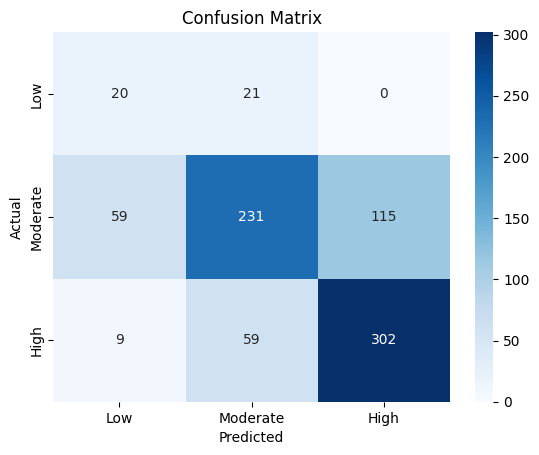


Feature Importances:
      Feature  Importance
1  Longitude    0.385411
0   Latitude    0.347980
2      Depth    0.266609
✅ Model saved as earthquake_risk_model.pkl


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# -----------------------------
# 1. Define risk levels based on magnitude
# -----------------------------
def risk_level(mag):
    if mag < 2.5:
        return 0  # Low
    elif mag < 4.0:
        return 1  # Moderate
    else:
        return 2  # High

# -----------------------------
# 2. Load your dataset
# -----------------------------
# Example: df = pd.read_csv("earthquake_data.csv")
df["Risk_Level"] = df["Magnitude"].apply(risk_level)

X = df[["Latitude", "Longitude", "Depth"]]
y = df["Risk_Level"]

# -----------------------------
# 3. Split Data
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# -----------------------------
# 4. Handle Class Imbalance using SMOTE
# -----------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# -----------------------------
# 5. Create Pipeline
# -----------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# -----------------------------
# 6. Hyperparameter Tuning
# -----------------------------
param_distributions = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_res, y_train_res)

# -----------------------------
# 7. Evaluate Model
# -----------------------------
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"✅ Best Parameters: {search.best_params_}")
print(f"📊 Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -----------------------------
# 8. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Moderate', 'High'],
            yticklabels=['Low', 'Moderate', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# -----------------------------
# 9. Feature Importance
# -----------------------------
importances = best_model.named_steps['rf'].feature_importances_
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feat_importance)

# -----------------------------
# 10. Save Model for API use
# -----------------------------
joblib.dump(best_model, "../saved_models/earthquake_risk_model.pkl")
print("✅ Model saved as earthquake_risk_model.pkl")
